In [11]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from timerForParsing import timeSince

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

print(device)

cuda:0


In [3]:
trainData = np.load('npy_data/NPYData.npy')

In [4]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=0.3)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size)).to(device)

In [5]:
def randomTrainingExample():
    i = random.randint(0, len(trainData) - 1)
    LEN = min(len(trainData[i]), 1600)
    r = random.randint(0, len(trainData[i]) - LEN - 2)
    if (LEN < 1600):
        r = 0
    line = trainData[i][r:r+LEN]
    inputs = Variable(torch.from_numpy(np.asarray(trainData[i][r:r+LEN])).long())
    targets = Variable(torch.from_numpy(np.asarray(trainData[i][r+1:r+LEN+1])).long())
    return inputs.to(device), targets.to(device)

In [6]:
def train(input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.init_hidden()
    rnn.zero_grad()    
    loss = 0
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
    loss.backward()
    optimizer.step()
    return output, loss.item() / input_line_tensor.size(0)

In [8]:
rnn = RNN(416, 1500, 416, 3).to(device)

In [9]:
all_losses = []

In [21]:
n_iters = 1200
print_every = 50
plot_every = 5
total_loss = 0

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn.parameters(), lr=0.001)

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        percent = iter / n_iters * 100
        print(timeSince(start, percent / 100), ' — ', percent, '%', ' — ', loss)

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

5m 16s (- 121m 20s)  —  4.166666666666666 %  —  2.3906787109375
10m 29s (- 115m 24s)  —  8.333333333333332 %  —  2.7147808837890626
15m 47s (- 110m 32s)  —  12.5 %  —  3.0400372314453126
21m 7s (- 105m 37s)  —  16.666666666666664 %  —  2.7893466186523437
26m 29s (- 100m 39s)  —  20.833333333333336 %  —  2.7115469360351563
31m 49s (- 95m 28s)  —  25.0 %  —  2.4698115539550782
37m 7s (- 90m 9s)  —  29.166666666666668 %  —  2.5579899597167968
42m 27s (- 84m 54s)  —  33.33333333333333 %  —  2.698353271484375
47m 47s (- 79m 39s)  —  37.5 %  —  2.5779629516601563
53m 6s (- 74m 20s)  —  41.66666666666667 %  —  2.576893310546875
58m 19s (- 68m 55s)  —  45.83333333333333 %  —  2.697485046386719
63m 34s (- 63m 34s)  —  50.0 %  —  2.265626983642578
68m 53s (- 58m 17s)  —  54.166666666666664 %  —  2.612686767578125
74m 14s (- 53m 1s)  —  58.333333333333336 %  —  2.4407638549804687
79m 35s (- 47m 45s)  —  62.5 %  —  2.557555847167969
84m 54s (- 42m 27s)  —  66.66666666666666 %  —  2.672479248046875

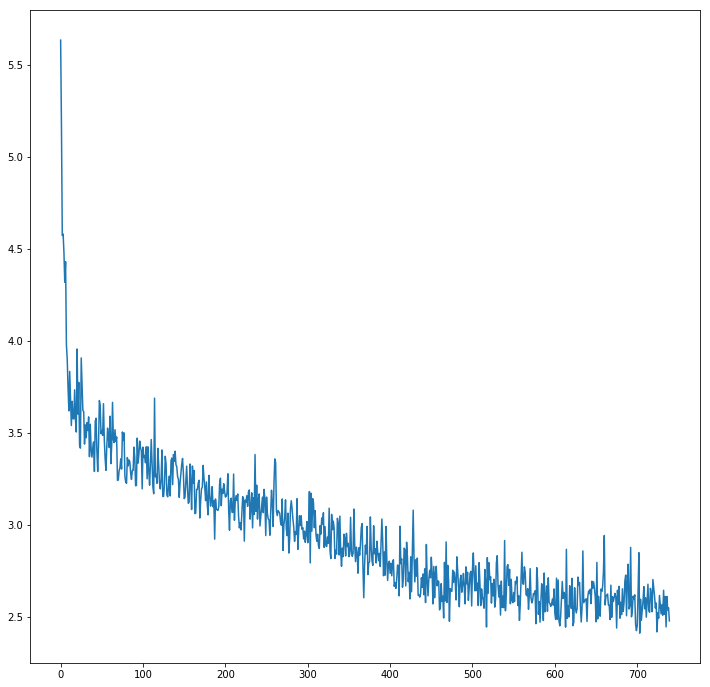

In [22]:
plt.figure(figsize=(12,12))
plt.plot(all_losses)
plt.show()

In [23]:
torch.save(rnn.state_dict(), 'model.pt')